# HW5: تولید موسیقی با استفاده از شبکه‌های عصبی بازگشتی
Welcome to Homework 5  &#128522;&#9996;

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div dir='rtl'style="text-align: right;font-family:verdana;">


ابتدا بسته‌ها و کتابخانه‌های مورد نیاز را import میکنیم، در طول اجرای کد هر پکیج دیگری که نیاز دارید، قرار دهید. 

In [2]:
!pip install -e /content/drive/MyDrive/University/Deep\ Learning/HW5/deeplearningcourse-20211226T165502Z-001/deeplearningcourse
import deeplearningcourse as dlc
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Obtaining file:///content/drive/MyDrive/University/Deep%20Learning/HW5/deeplearningcourse-20211226T165502Z-001/deeplearningcourse
  Attempting uninstall: deeplearningcourse
    Found existing installation: deeplearningcourse 0.0.0
    Can't uninstall 'deeplearningcourse'. No files were found to uninstall.
  Running setup.py develop for deeplearningcourse




## A) مجموعه داده

<div dir='rtl'style="text-align: right;font-family:verdana;">

ابتدا دیتاست مورد نظر را از طریق پکیجی که در گوگل درایو قرار دایم، load کرده و مراحل بعدی را انجام می‌دهیم. 
همانطور که گقتیم دیتاست مورد نظر تعدادی آهنگ محلی ایرلندی است که با نماد ABC نشان داده می‌شود. برای درک بهتر می‌توانیم یکی از این آهنگ‌ها را در نماد ABC نشان دهیم. 
همچنین می‌توانیم این اهنگ را به صورت صوتی نمایش داده و پخش کنیم.





*  یکی از نکات مهمی که باید به آن توجه کنید این است که نماد موسیقی فقط شامل اطلاعاتی در مورد نت‌های در حال پخش نمی‌باشد بلکه علاوه بر این اطلاعات، اطلاعات دیگری مانند عنوان آهنگ، کلید و tempo آهنگ نیز وجود دارد. 



In [3]:

songs = dlc.P1.load_data()
examplesong = songs[25]
print(examplesong)



Found 817 songs in text
X:24
T:Flowers of Edinburgh
Z: id:dc-hornpipe-23
M:C|
L:1/8
K:G Major
GE|D2DE G2GA|BGBd cBAG|FGEF DEFG|A2FA D2GE|!
D2DE G2GA|BGBd efge|dcBA GFGA|B2G2 G2:|!
(3def|g2gf gbag|f2fe fagf|edef gfed|B2e2 e2ge|!
dBGB d2Bd|edef g2ge|dcBA GFGA|B2G2 G2:|


In [4]:
joined_songs = "\n\n".join(songs) 
vocab = sorted(set(joined_songs))
print( len(vocab))

83


<div dir='rtl'style="text-align: right;font-family:verdana;">


روند کار به این صورت است که دنباله‌ای از کاراکترها را به مدل وارد می‌کنیم و مدل را برای پیش‌بینی خروجی که کاراکتر بعدی در هر تایم زمانی است، آموزش می‌دهیم. مدل‌های RNN یک intenal state دارند که به عناصر دیده شده قبلی بستگی دارد، بنابراین اطلاعات مربوط به همه کاراکترهای دیده شده تا یک لحظه مشخص برای ایجاد پیش‌بینی گرفته می‌شوند. 





###  A-1) تبدیل متن به بردار

<div dir='rtl'style="text-align: right;font-family:verdana;">



قبل از شروع آموزش مدل RNN باید یک نمایش عددی از مجوعه داده‌های متنی خود ایجاد کنیم. برای این کار می‌توانیم دو جدول مراجعه ایجاد کنیم که یکی از آنها کاراکترها را به عدد نگاشت می‌کند و دیگری اعداد را به کاراکتر برمی‌گراند. فعلا این کار را برای کاراکترهای منحصر به فرد در دیتاست انجام می‌دهیم. 

همچنین می‌توانید این نمایش عددی را برای داده‌های متن مشاهده کنید:

In [5]:

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [6]:

for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:2d},'.format(repr(char), char2idx[char]))

  '\n':  0,
  ' ' :  1,
  '!' :  2,
  '"' :  3,
  '#' :  4,
  "'" :  5,
  '(' :  6,
  ')' :  7,
  ',' :  8,
  '-' :  9,
  '.' : 10,
  '/' : 11,
  '0' : 12,
  '1' : 13,
  '2' : 14,
  '3' : 15,
  '4' : 16,
  '5' : 17,
  '6' : 18,
  '7' : 19,


<div dir='rtl'style="text-align: right;font-family:verdana;">

**تمرین:**

تابعی بنویسید که همه songs string ها را به نمایش عددی تبدیل کند. توجه داشته باشید که خروجی این تابع باید یک np.array با N عنصر باشد که N تعداد کاراکترهای رشته ورودی است. خروجی تابع را vectorized_songs نامگذاری کنید و در مراحل بعدی استفاده کنید.

In [7]:
def vectorize(string):
   return np.array([char2idx[c] for c in string])

  # ...


In [8]:
vectorized_songs = vectorize(joined_songs)

<div dir='rtl'style="text-align: right;font-family:verdana;">


همچنین می‌توان نحوه نگاشت اولین قسمت متن را به یک نمایش integer نمایش داد.

In [9]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(joined_songs[:20]), vectorized_songs[:20]))

"X:1\nT:Alexander's\nZ:" ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79 56 69 59 60 73  5 74  0 51 22]




## B)  ایجاد نمونه‌های آموزش و لیبل‌ها

<div dir='rtl'style="text-align: right;font-family:verdana;">

گام بعدی این است که متن را به دنباله‌های نمونه‌ای که در طول آموزش از آن استفاده می‌کنیم، تبدیل کنیم. هر دنباله ورودی که به مدل RNN می‌دهیم دارای یک seq_length است، همچنین باید یک دنباله target برای هر ورودی تعریف کنیم که در آموزش RNN برای پیش‌بینی کاراکتر بعدی استفاده می‌شود. 

مثلا اگر فرض کنیم seq_length برابر با چهار باشد و متن ورودی ما "Hello"  باشد، دنباله هدف "ello" است. 



*   روش دسته‌ای به ما این امکان را می‌دهد که این جریان کاراکترها را به دنباله‌هایی با اندازه‌های دلخواه تبدیل کنیم.

* 
تابع creat_examples نمونه‌های مورد نظر ما را ایجاد می‌کند و از آن برای تولید داده‌های آموزش و لیبل‌های آن‌ها استفاده می‌کنیم. 

In [10]:
#  creat training examples and targets 

def creat_examples(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]


  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

<div dir='rtl'style="text-align: right;font-family:verdana;">


   برای درک بهتر می‌توانید چند کاراکتر اول در متن را به همراه target آن مشاهده کنید.




In [11]:

x_batch, y_batch = creat_examples(vectorized_songs, seq_length= 5, batch_size= 1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 1 (' ')
  expected output: 27 ('B')
Step   1
  input: 27 ('B')
  expected output: 58 ('c')
Step   2
  input: 58 ('c')
  expected output: 82 ('|')
Step   3
  input: 82 ('|')
  expected output: 26 ('A')
Step   4
  input: 26 ('A')
  expected output: 25 ('>')




## C) شبکه‌های عصبی بازگشتی

### C-1) تعریف مدل

<div dir='rtl'style="text-align: right;font-family:verdana;">

پس از آماده‌سازی داده‌های آموزش و تست، می‌خواهیم یک شبکه عصبی بازگشتی طراحی کنیم، آموزش دهیم و سپس از مدل آموزش دیده برای تولید موسیقی جدید استفاده کنیم. 

**تمرین:**

مدل پیشنهادی خود را ارائه کنید و آن را آموزش دهید:

In [12]:
# Defining the RNN Model 

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(len(vocab),256),
                             tf.keras.layers.LSTM(1024,return_sequences=True),
                             tf.keras.layers.Dense(128,activation='relu'),
                             tf.keras.layers.Dense(len(vocab)),
])

# TODO

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         21248     
                                                                 
 lstm (LSTM)                 (None, None, 1024)        5246976   
                                                                 
 dense (Dense)               (None, None, 128)         131200    
                                                                 
 dense_1 (Dense)             (None, None, 83)          10707     
                                                                 
Total params: 5,410,131
Trainable params: 5,410,131
Non-trainable params: 0
_________________________________________________________________


<div dir='rtl'style="text-align: right;font-family:verdana;">

**تمرین:**

با در نظر گرفتن طول ورودی برابر با 100 و استفاده از تابع pred اندازه خروجی را نشان دهید:
 

*   
توجه داشته باشید که می‌توان مدل را بر روی ورودی‌هایی با هر اندازه آموزش داد.









In [14]:
x, y = creat_examples(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print(f'output shape is: {pred.shape}')

# TODO

output shape is: (32, 100, 83)


<div dir='rtl'style="text-align: right;font-family:verdana;">

همچنین می‌توانیم رمزگشایی انجام دهیم تا ورودی را با متن پیش‌بینی شده توسط مدل آموزش ندیده مقایسه کنیم:

In [15]:
sampled_indices = tf.random.categorical(pred[10], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([18, 25, 31, 18, 49, 39, 58, 76, 59, 17, 27, 15, 76, 80, 40, 66, 61,
       23, 56, 64, 43, 81, 63, 22, 10, 30,  0, 15, 76,  1, 47, 74, 65, 10,
       42,  8, 13, 38, 59,  8, 21, 22, 49, 57, 80, 12, 50, 34, 27, 44, 15,
       27, 74, 26, 74, 62, 74, 25, 66, 21, 18, 22, 17, 58, 67, 54, 48, 50,
        9,  8, 43, 19, 79, 36, 28, 24, 75, 59, 55, 68, 56, 74, 62, 57, 22,
       49,  6, 81, 77, 45, 19, 13, 37, 14, 38, 21, 81, 70, 79,  8])

In [16]:
print("input: \n", repr("".join(idx2char[x[10]])))
print("char prediction: \n", repr("".join(idx2char[sampled_indices])))

input: 
 'g|fdad bdad|gfge dcBc|!\ndggf gfed|eaag agef|g3e dcBc|dBcA BGG2:|!\n\nX:102\nT:Fermoy Lasses\nZ: id:dc-re'
char prediction: 
 '6>F6XNcud5B3uyOkf<aiRzh:.E\n3u Vsj.Q,1Md,9:Xby0YIBS3BsAsgs>k96:5cl^WY-,R7xKC=td_masgb:X(zvT71L2M9zox,'


### C-2) آموزش مدل

<div dir='rtl'style="text-align: right;font-family:verdana;">



*   همانطور که مشاهده می‌کنیم متن تولید شده توسط مدل آموزش ندیده بسیار بی معنی است و باید برای بهبود مدل را آموزش دهیم. 





**تمرین:**

تابع هزینه مناسب را برای محاسبه و برگرداندن خطا بین لیبل‌های واقعی و پیش‌بینی شده تعریف کنید. 
 ( از تابع هزینه sparse_categorical_crossentropy  استفاده کنید.)

In [17]:
# Defining the loss function
def loss_function(labels, logits):
  # TODO
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

<div dir='rtl'style="text-align: right;font-family:verdana;">


**تمرین:**

تابع خطا را برای محاسبه و برگرداندن مقدار خطا بین مقدار واقعی و مقدار پیش‌بینی شده مدل آموزش ندیده اعمال کنید و مقدار خطا را نشان دهید:

In [18]:
# TODO

print(loss_function(y,pred))
print(f'mean of loss is {tf.reduce_mean(loss_function(y,pred))}')

tf.Tensor(
[[4.417392  4.422079  4.4161267 ... 4.4218636 4.4205766 4.4169955]
 [4.4206786 4.415649  4.4244013 ... 4.4297633 4.4125996 4.4172626]
 [4.4205203 4.4185367 4.417004  ... 4.4143367 4.416124  4.417022 ]
 ...
 [4.4194727 4.416106  4.419025  ... 4.4158673 4.417187  4.424716 ]
 [4.416881  4.420334  4.413082  ... 4.4197054 4.4235    4.4309626]
 [4.414528  4.421061  4.423133  ... 4.418509  4.416497  4.424828 ]], shape=(32, 100), dtype=float32)
mean of loss is 4.418978214263916


<div dir='rtl'style="text-align: right;font-family:verdana;">


**تمرین:**

با تعریف هایپرپارامترها به صورت مناسب مدل را آموش دهید:



-    هایپرپارامترهای مناسب را برای شبکه انتخاب کرده و نحوه به دست آوردن این هایپرپارامترها را توضیح دهید.

-  بعد از تعریف هایپرپارامترها مدل را آموزش داده و دقت آن را روی داده‌های آموزش گزارش دهید. همچنین نمودار خطا را در طی فرایند آموزش رسم کنید.
-    تعداد ایپوک‌ها در مرحله آموزش چگونه بر عملکرد مدل تاثیر می‌گذارند؟
    



In [19]:
### Hyperparameter setting and optimization ###
num_training_iterations =  5000
batch_size =   16
seq_length =   100
learning_rate = 1e-3


# Checkpoint location:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

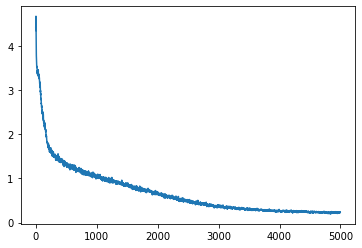

100%|██████████| 5000/5000 [10:19<00:00,  8.07it/s]


last loss: 0.2162719964981079


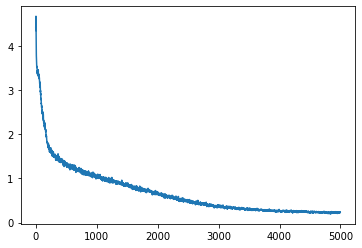

In [20]:
### train model

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(x_train, y_train):
    with tf.GradientTape() as tape:
        logits = model(x_train,training=True) # Load the images
        loss = loss_function(y_train,logits)

    # Backpropagation
    grads_bp = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads_bp, model.trainable_variables))
    return loss


from tqdm import tqdm


loss_history = dlc.P4.LossHistory(smoothing_factor=0.6) 
# loss_history = dlc.P4.LossHistory() 
# plotter = dlc.P4.PeriodicPlotter(sec=2, scale='semilogy')
plotter = dlc.P4.PeriodicPlotter(sec=2)
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

# training 
for epoch in tqdm(range(num_training_iterations)):
    # Choosing a batch of training
    x_train, y_train = creat_examples(vectorized_songs, seq_length=seq_length, batch_size=batch_size)
    loss = train_step(x_train,y_train)

    # Record the loss function
    loss_history.append(tf.reduce_mean(loss))
    plotter.plot(loss_history.get())

    if epoch % 200 == 0:
      model.save_weights(checkpoint_prefix)


model.save_weights(checkpoint_prefix)
print(f"last loss: {loss_history.get()[-1]}")




## D) تولید موسیقی با استفاده از شبکه‌های عصبی بازگشتی

<div dir='rtl'style="text-align: right;font-family:verdana;">

اکنون می‌توانیم از RNN آموزش دیده برای تولید موسیقی استفاده کنیم. هنگام تولید موسیقی، ما باید مدل را به نوعی تغذیه کنیم تا شروع به کار کند. هنگامی که یک seed تولید شده داریم، می‌توانیم هر یک از کاراکترهای پی در پی را به صورت تکراری پیش‌بینی کنیم. 




*   به این نکته توجه داشته باشید که مدل RNN از یک لایه softmax  در لایه آخر استفاده می‌کند که برای نتیجه‌گیری به طور مکرر از این توزیع‌ها نمونه می‌گیریم و سپس از نمونه‌های خود برای کدگذاری آهنگ تولید شده قالب ABC استفاده می‌کنیم. 

**تمرین:**

تابع زیر را برای تولید موسیقی با استفاده از مدل آموزش دیده خود تمکیل کنید:


In [21]:

def text_generation(model, start_string, generation_length=1000):
  start_vec = tf.expand_dims([char2idx[c] for c in start_string],0)
  result = [c for c in start_string]

  for i in range(generation_length):
    out = model(start_vec,training=False)

    index = tf.random.categorical(out[0],1)

    start_vec = index

    result.append(idx2char[index[0,0].numpy()])


  return result


text = ''.join(text_generation(model, 'X', 1000))

print(text)


# TODO

X:D2G2 Do d|GEDFA|cBd feg|!
K:de2|gge2|d|eaf ocB A edcAFA enia|gd|ga|f3|!
Kid|c-1/ey bfeg|!
GB|ed2AGA|!

Z:C

X:|fgdBdBAGEG dcBG2:GAG t/d2:12a-D2f|c Riga2e^ckefdc2A|!

z|edc|b c2|!
A|!
K:|gdd2:|gec-jora|A BECn
f c AFGFG|!
g Ma e2 ydBAA BAFFAGE2g|g AB ooc|gfgegdBAd|bgga02 DG2
Z: B|ea EDE|D|!
X:d2dBGGGFGA2efdAF|e|ajilily's
Z:Hoc-3cd|!
L:5
A DAF3: Jor
X: (3227
e f38
Z:AAA2 BG|!
z|!
K: e|G B|fajiagef e e:|Bdfgfajoron

Z:BGDGE2dcAGFD d A e-7
Mgfaz|dce ef|ED2|!
as
g ajorAEEF e e|!
dBdBABG2 BA|!
K:IED:|d2:1/4
Ma|eAd|!

Z:dc|F2e/ G A,C
cc|!
Z:F tedeg Drc3 F|d|c-roul
f ce d d3 edc|dBA4
ga|
BdBAG Bdee|egea>f zBd B2FGA,C
g2A|gd2d|E2DD:GFAB|!
Z: g f|gan g|AF|!
F e'2c-7
Z:|c T: e BAG|fdBG fd2ag e e|B2|fgg B|GFEBddc2|!

X: AB|el cAEEF ea-r
Ha-rt E A32 E3FAFA,3c ga fd gee
B|fed ige|ec,2AFAF tr
GA fgenmiccdc ABGFA3 dc2 cAG|f fd d1/8
Z:|!
d FDGAG jon


K:|!
K:GFGE3|ge eefgeB|BGABG BA|g2|d|geBG|a DGrae f|!
K:|ge faf BGDFGA ba A ege d dA fan
K:12A GED2el
dc-red eaig gaf AAG,2gfeg2:C
X: ee G e>c|dg|AGB G2

<div dir='rtl'style="text-align: right;font-family:verdana;">


**تمرین:**

اکنون می‌توانید موسیقی‌های تولید شده (text)
را به صورت زیر یا به هر طریقی که می‌توانید، در قالب ABC نشان داده یا پخش کنید.

In [22]:
songs = dlc.P1.extract_songsnippet(text)
for i, song in enumerate(songs): 
  dlc.P1.play(song)
  print(song, end="\n\n\n\n")

Found 7 songs in text
X:D2G2 Do d|GEDFA|cBd feg|!
K:de2|gge2|d|eaf ocB A edcAFA enia|gd|ga|f3|!
Kid|c-1/ey bfeg|!
GB|ed2AGA|!



Z:C



X:|fgdBdBAGEG dcBG2:GAG t/d2:12a-D2f|c Riga2e^ckefdc2A|!



z|edc|b c2|!
A|!
K:|gdd2:|gec-jora|A BECn
f c AFGFG|!
g Ma e2 ydBAA BAFFAGE2g|g AB ooc|gfgegdBAd|bgga02 DG2
Z: B|ea EDE|D|!
X:d2dBGGGFGA2efdAF|e|ajilily's
Z:Hoc-3cd|!
L:5
A DAF3: Jor
X: (3227
e f38
Z:AAA2 BG|!
z|!
K: e|G B|fajiagef e e:|Bdfgfajoron



Z:BGDGE2dcAGFD d A e-7
Mgfaz|dce ef|ED2|!
as
g ajorAEEF e e|!
dBdBABG2 BA|!
K:IED:|d2:1/4
Ma|eAd|!



Z:dc|F2e/ G A,C
cc|!
Z:F tedeg Drc3 F|d|c-roul
f ce d d3 edc|dBA4
ga|
BdBAG Bdee|egea>f zBd B2FGA,C
g2A|gd2d|E2DD:GFAB|!
Z: g f|gan g|AF|!
F e'2c-7
Z:|c T: e BAG|fdBG fd2ag e e|B2|fgg B|GFEBddc2|!



X: AB|el cAEEF ea-r
Ha-rt E A32 E3FAFA,3c ga fd gee
B|fed ige|ec,2AFAF tr
GA fgenmiccdc ABGFA3 dc2 cAG|f fd d1/8
Z:|!
d FDGAG jon



